In [ ]:
! pip install transformers plotly datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.6 MB/s eta 0:00:00


In [6]:
! pip install --user kaggle

Note: you may need to restart the kernel to use updated packages.


In [2]:
! mkdir ~/.kaggle

In [3]:
! mv kaggle.json ~/.kaggle

In [2]:
! ~/.local/bin/kaggle competitions download -c fake-news

100%|██████████████████████████████████████| 46.5M/46.5M [00:03<00:00, 12.5MB/s]
100%|██████████████████████████████████████| 46.5M/46.5M [00:03<00:00, 12.4MB/s]


In [9]:
! unzip fake-news.zip

Archive:  fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


In [5]:
! rm -rf space-model
! git clone https://github.com/StepanTita/space-model.git

Cloning into 'space-model'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 128 (delta 33), reused 111 (delta 19), pack-reused 0
Receiving objects: 100% (128/128), 29.56 MiB | 5.29 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [1]:
import sys

sys.path.append('space-model')

In [2]:
import math
import json
from collections import Counter
import random
import os

import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, get_linear_schedule_with_warmup

from datasets import load_dataset, Dataset, DatasetDict

from space_model.model import *
from space_model.loss import *

/home/stepan/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
SEED = 42

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=SEED)

In [5]:
def on_gpu(f):
    def wrapper(*args):
        if torch.cuda.is_available():
            return f(*args)
        else:
            print('cuda unavailable')
    return wrapper

In [6]:
if torch.cuda.is_available():
    ! pip install pynvml
    from pynvml import *
    from numba import cuda

@on_gpu
def print_gpu_utilization(dev_id):
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(dev_id)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    except Exception as e:
        print(e)

@on_gpu
def free_gpu_cache(dev_id=0):
    print("Initial GPU Usage")
    print_gpu_utilization(dev_id)

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization(dev_id)

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

Defaulting to user installation because normal site-packages is not writeable


In [7]:
device_id = 1

In [8]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [9]:
torch.cuda.set_device(device)

In [10]:
MODEL_NAME = 'bert-base-cased'
MODELS_PATH = 'models'
DATASET_NAME = 'covid-fake-news'

SEED = 42
NUM_EPOCHS = 5
BATCH_SIZE = 32
MAX_SEQ_LEN = 512
LEARNING_RATE = 2e-5
MAX_GRAD_NORM = 1000

In [11]:
train_df = pd.read_csv('data/covid_train.csv', index_col=0)
train_df

,tweet,label
id,,
1,The CDC currently reports 99031 deaths. In gen...,real
2,States reported 1121 deaths a small rise from ...,real
3,Politically Correct Woman (Almost) Uses Pandem...,fake
4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
5,Populous states can generate large case counts...,real
...,...,...
6416,A tiger tested positive for COVID-19 please st...,fake
6417,???Autopsies prove that COVID-19 is??� a blood...,fake
6418,_A post claims a COVID-19 vaccine has already ...,fake


In [12]:
test_df = pd.read_csv('data/covid_test.csv', index_col=0)
test_df

,tweet,label
id,,
1,Our daily update is published. States reported...,real
2,Alfalfa is the only cure for COVID-19.,fake
3,President Trump Asked What He Would Do If He W...,fake
4,States reported 630 deaths. We are still seein...,real
5,This is the sixth time a global health emergen...,real
...,...,...
2136,#CoronaVirusUpdates: State-wise details of Tot...,real
2137,Tonight 12(midnight) onwards Disaster Manageme...,fake
2138,296 new cases of #COVID19Nigeria; Plateau-85 E...,real


In [13]:
val_df = pd.read_csv('data/covid_val.csv', index_col=0)
val_df

,tweet,label
id,,
1,Chinese converting to Islam after realising th...,fake
2,11 out of 13 people (from the Diamond Princess...,fake
3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
4,Mike Pence in RNC speech praises Donald Trump’...,fake
5,6/10 Sky's @EdConwaySky explains the latest #C...,real
...,...,...
2136,Donald Trump wrongly claimed that New Zealand ...,fake
2137,Current understanding is #COVID19 spreads most...,real
2138,Nothing screams “I am sat around doing fuck al...,fake


In [14]:
def encode_label(s: str):
    if s == 'fake':
        return 1
    else:
        return 0

In [15]:
train_df['label'] = train_df['label'].apply(encode_label)
val_df['label'] = val_df['label'].apply(encode_label)
test_df['label'] = test_df['label'].apply(encode_label)
train_df

,tweet,label
id,,
1,The CDC currently reports 99031 deaths. In gen...,0
2,States reported 1121 deaths a small rise from ...,0
3,Politically Correct Woman (Almost) Uses Pandem...,1
4,#IndiaFightsCorona: We have 1524 #COVID testin...,0
5,Populous states can generate large case counts...,0
...,...,...
6416,A tiger tested positive for COVID-19 please st...,1
6417,???Autopsies prove that COVID-19 is??� a blood...,1
6418,_A post claims a COVID-19 vaccine has already ...,1


In [16]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df[['tweet', 'label']]),
    'test': Dataset.from_pandas(test_df[['tweet', 'label']]),
    'val': Dataset.from_pandas(val_df[['tweet', 'label']])
})
dataset

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label', 'id'],
        num_rows: 6420
    })
    test: Dataset({
        features: ['tweet', 'label', 'id'],
        num_rows: 2140
    })
    val: Dataset({
        features: ['tweet', 'label', 'id'],
        num_rows: 2140
    })
})

In [17]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [18]:
tokenized_dataset = dataset.map(lambda x: tokenizer(x['tweet'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN, return_tensors='pt'), batched=True)
tokenized_dataset.set_format('torch', device=device)
tokenized_dataset

Map:   0%|          | 0/6420 [00:00<?, ? examples/s]

Map:   0%|          | 0/2140 [00:00<?, ? examples/s]

Map:   0%|          | 0/2140 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6420
    })
    test: Dataset({
        features: ['tweet', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2140
    })
    val: Dataset({
        features: ['tweet', 'label', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2140
    })
})

In [19]:
base_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
base_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
for p in base_model.bert.parameters():
    p.requires_grad = False
# for p in base_model.pre_classifier.parameters():
#     p.requires_grad = True

In [21]:
count_parameters(base_model)

108311810

In [21]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        model.eval()
        return f(model, *args, **kwargs)
    return wrapper

def train(f):
    def wrapper(model, *args, **kwargs):
        model.train()
        return f(model, *args, **kwargs)
    return wrapper

In [22]:
@train
def train_epoch(model, train_dataloader, optimizer, scheduler, config):
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for step, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        targets = batch['label'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets) # (B, Seq_Len, 2)

        loss, logits = outputs.loss, outputs.logits

        probs = F.softmax(logits, dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in targets.cpu()]
        
        if (step + 1) % config['gradient_accumulation_steps'] == 0:
            scheduler.step()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        batch_loss = loss.item()
        if config['gradient_accumulation_steps'] > 1:
            batch_loss = batch_loss / config['gradient_accumulation_steps']

        train_loss += batch_loss
    return train_loss, train_preds, train_labels

@eval
def eval_epoch(model, val_dataloader):
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():

        for step, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['label'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)

            loss, logits = outputs.loss, outputs.logits

            probs = F.softmax(logits, dim=-1).cpu()
            pred = torch.argmax(probs, dim=-1) # (B)
            val_preds += pred.detach().tolist()
            val_labels += [l.item() for l in targets.cpu()]

            val_loss += loss.item()
    return val_loss, val_preds, val_labels

In [23]:
def training(model, train_data, val_data, config):
    model = model.to(device)

    optimizer = torch.optim.AdamW(
        params=model.parameters(),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['epochs'])
    steps_per_epoch = len(train_data) / config['batch_size']
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=config['num_warmup_steps'],
        num_training_steps=num_train_steps,
    )

    print(f'Train steps: {num_train_steps}')
    print(f'Steps per epoch: {steps_per_epoch}')

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=config['batch_size'])

    history = {
        'train_losses': [],
        'val_losses': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
    }

    for epoch_num in range(config['epochs']):
        print(f'Epoch: {epoch_num + 1}')

        # train stage
        train_loss, train_preds, train_labels = train_epoch(model, train_dataloader, optimizer, scheduler, config)

        # eval stage
        val_loss, val_preds, val_labels = eval_epoch(model, val_dataloader)

        # metrics
        train_acc = accuracy_score(train_labels, train_preds)
        val_acc = accuracy_score(val_labels, val_preds)
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        train_precision = precision_score(train_labels, train_preds)
        val_precision = precision_score(val_labels, val_preds)
        train_recall = recall_score(train_labels, train_preds)
        val_recall = recall_score(val_labels, val_preds)

        history['train_losses'].append(train_loss / len(train_dataloader))
        history['val_losses'].append(val_loss / len(val_dataloader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)

        print()
        print(f'Train loss: {train_loss / len(train_dataloader)} | Val loss: {val_loss / len(val_dataloader)}')
        print(f'Train acc: {train_acc} | Val acc: {val_acc}')
        print(f'Train f1: {train_f1} | Val f1: {val_f1}')
        print(f'Train precision: {train_precision} | Val precision: {val_precision}')
        print(f'Train recall: {train_recall} | Val recall: {val_recall}')

    free_gpu_cache(device_id)
    return history

In [24]:
def plot_scheduler_stats(stats):
    epochs_x = list(range(1, len(stats['lr_history']) + 1))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(epochs_x, stats['lr_history'])
    ax1.set_title('Learning rates')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('learning_rate')

    ax2.plot(epochs_x, stats['weights_history'])
    ax2.set_title('Weights')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('weight')

    plt.title('Scheduler stats')
    
    plt.show()

In [25]:
ids = tokenized_dataset['test'][1]['input_ids'].unsqueeze(0)
mask = tokenized_dataset['test'][1]['attention_mask'].unsqueeze(0)
targets = tokenized_dataset['test'][1]['label'].unsqueeze(0)

ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)

out = base_model(ids, mask, labels=targets)
out.loss

tensor(0.5741, device='cuda:1', grad_fn=<NllLossBackward0>)

In [26]:
config = {
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'gradient_accumulation_steps': 1,
    'fp16': False,
    'lr': LEARNING_RATE,
    'max_grad_norm': MAX_GRAD_NORM,
    'weight_decay': 0.01,
    'num_warmup_steps': 0,
}

In [27]:
history = training(base_model, tokenized_dataset['train'], tokenized_dataset['val'], config)

Train steps: 1003
Steps per epoch: 200.625
Epoch: 1


100%|███████████████████████████████████████████| 67/67 [00:22<00:00,  3.04it/s]



Train loss: 0.24361321445443293 | Val loss: 0.09892841616172844
Train acc: 0.8975077881619937 | Val acc: 0.9649532710280374
Train f1: 0.8969696035501873 | Val f1: 0.9648718940352475
Train precision: 0.9147099447513812 | Val precision: 0.9646017699115044
Train recall: 0.865686274509804 | Val recall: 0.961764705882353
Epoch: 2


100%|███████████████████████████████████████████| 67/67 [00:22<00:00,  3.04it/s]



Train loss: 0.06738879851561355 | Val loss: 0.08543544810668413
Train acc: 0.9786604361370717 | Val acc: 0.9724299065420561
Train f1: 0.978608281353659 | Val f1: 0.9723385250996226
Train precision: 0.9802826158396319 | Val precision: 0.9819458375125376
Train recall: 0.9748366013071895 | Val recall: 0.9598039215686275
Epoch: 3


100%|███████████████████████████████████████████| 67/67 [00:22<00:00,  3.04it/s]



Train loss: 0.026908338551794118 | Val loss: 0.09276305744598216
Train acc: 0.9912772585669782 | Val acc: 0.9761682242990655
Train f1: 0.9912581699346406 | Val f1: 0.9761039340929248
Train precision: 0.9908496732026144 | Val precision: 0.9801783944499505
Train recall: 0.9908496732026144 | Val recall: 0.9696078431372549
Epoch: 4


100%|███████████████████████████████████████████| 67/67 [00:22<00:00,  3.04it/s]



Train loss: 0.011611287608344237 | Val loss: 0.09439691284900781
Train acc: 0.9970404984423676 | Val acc: 0.9775700934579439
Train f1: 0.9970338037673221 | Val f1: 0.9775084868676889
Train precision: 0.997708674304419 | Val precision: 0.9821428571428571
Train recall: 0.996078431372549 | Val recall: 0.9705882352941176
Epoch: 5


100%|███████████████████████████████████████████| 67/67 [00:22<00:00,  3.04it/s]


Train loss: 0.0069783302898569705 | Val loss: 0.09651369735626365
Train acc: 0.9989096573208722 | Val acc: 0.97803738317757
Train f1: 0.9989072231745721 | Val f1: 0.9779802566664018
Train precision: 0.9993457638207393 | Val precision: 0.9812067260138477
Train recall: 0.9983660130718954 | Val recall: 0.9725490196078431
Initial GPU Usage
GPU memory occupied: 23951 MB.
GPU Usage after emptying the cache
GPU memory occupied: 3883 MB.


In [28]:
def plot_results(history, do_val=True):
    fig, ax = plt.subplots(figsize=(8, 8))

    x = list(range(0, len(history['train_losses'])))

    # loss

    ax.plot(x, history['train_losses'], label='train_loss')

    if do_val:
        ax.plot(x, history['val_losses'], label='val_loss')

    plt.title('Train / Validation Loss')
    plt.legend(loc='upper right')

    # accuracy

    if 'train_acc' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_acc'], label='train_acc')

        if do_val:
            ax.plot(x, history['val_acc'], label='val_acc')

    plt.title('Train / Validation Accuracy')
    plt.legend(loc='upper right')

    # f1-score

    if 'train_f1' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_f1'], label='train_f1')

        if do_val:
            ax.plot(x, history['val_f1'], label='val_f1')

        plt.title('Train / Validation F1')
        plt.legend(loc='upper right')

    # precision

    if 'train_precision' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_precision'], label='train_precision')

        if do_val:
            ax.plot(x, history['val_precision'], label='val_precision')

        plt.title('Train / Validation Precision')
        plt.legend(loc='upper right')

    # recall

    if 'train_recall' in history:
        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x, history['train_recall'], label='train_recall')

        if do_val:
            ax.plot(x, history['val_recall'], label='val_recall')

        plt.title('Train / Validation Recall')
        plt.legend(loc='upper right')

    fig.show()

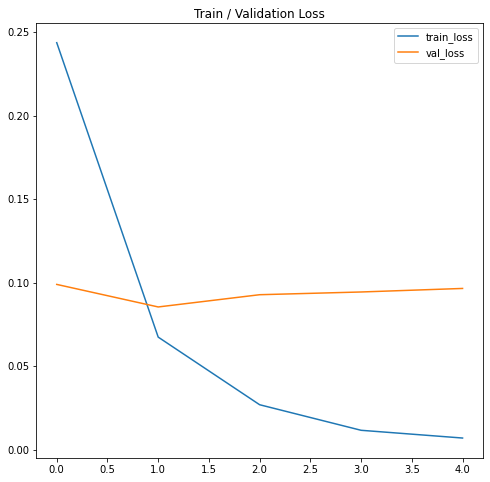

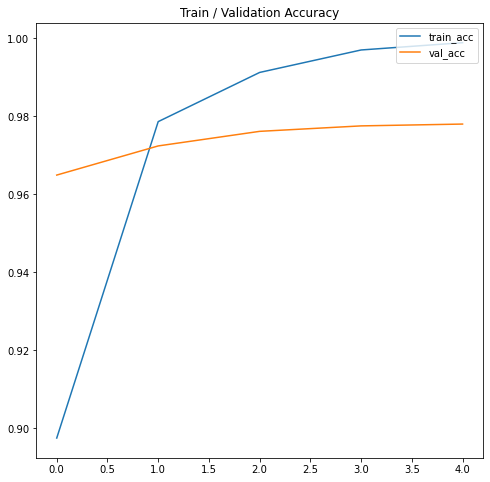

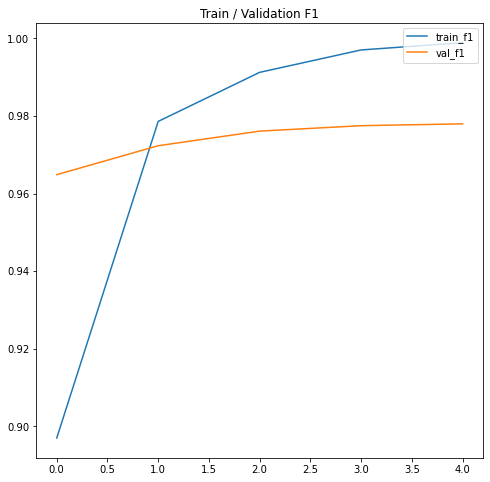

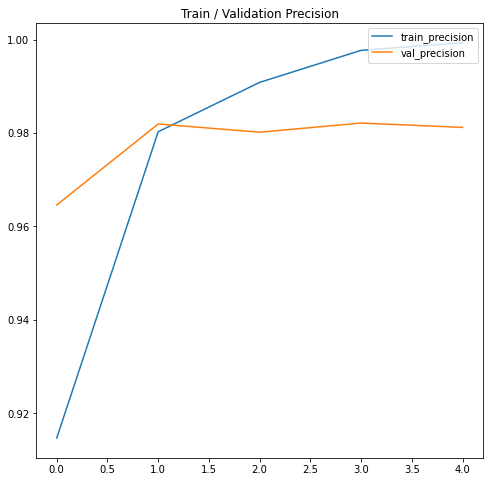

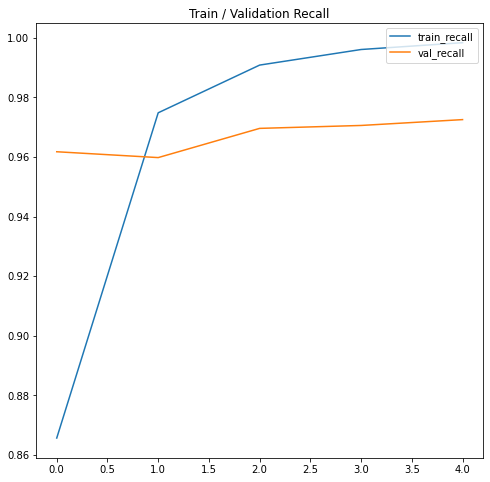

In [29]:
plot_results(history)

In [36]:
torch.save(base_model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}_{MODEL_NAME}_{NUM_EPOCHS}.bin')

In [30]:
val_dataset = tokenized_dataset['test']

In [31]:
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config['batch_size'])

In [32]:
val_loss, val_preds, val_labels = eval_epoch(base_model, val_dataloader)

100%|███████████████████████████████████████████| 67/67 [00:20<00:00,  3.24it/s]


In [33]:
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds)
val_recall = recall_score(val_labels, val_preds)

In [34]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.08461968362880454
Val acc: 0.9752336448598131
Val f1: 0.9751805276337099
Val precision: 0.9735553379040157
Val recall: 0.9745098039215686


In [34]:
iterations = 14
for i in range(iterations):
    print(f'Iteration: {i + 1}')
    history = training(base_model, tokenized_dataset['train'], tokenized_dataset['val'], config)
    
    val_loss, val_preds, val_labels = eval_epoch(base_model, val_dataloader)
    
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_precision = precision_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    
    print(f'Val loss: {val_loss / len(val_dataloader)}')
    print(f'Val acc: {val_acc}')
    print(f'Val f1: {val_f1}')
    print(f'Val precision: {val_precision}')
    print(f'Val recall: {val_recall}')

Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.38s/it]



Train loss: 0.7065824568271637 | Val loss: 0.6938533981641134
Train acc: 0.4806853582554517 | Val acc: 0.5130841121495328
Train f1: 0.472618661959095 | Val f1: 0.43071796709934423
Train precision: 0.46701974000962926 | Val precision: 0.46405228758169936
Train recall: 0.6339869281045751 | Val recall: 0.1392156862745098
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6976014008888831 | Val loss: 0.6917231745190091
Train acc: 0.5042056074766356 | Val acc: 0.514018691588785
Train f1: 0.4850894255995234 | Val f1: 0.3740324729092414
Train precision: 0.47103155911446065 | Val precision: 0.4074074074074074
Train recall: 0.32679738562091504 | Val recall: 0.043137254901960784
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6963237203084506 | Val loss: 0.6900688807169596
Train acc: 0.5121495327102804 | Val acc: 0.5299065420560748
Train f1: 0.49234630399234747 | Val f1: 0.4145277528487123
Train precision: 0.48279158699808794 | Val precision: 0.5411764705882353
Train recall: 0.3300653594771242 | Val recall: 0.09019607843137255
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6962072918048272 | Val loss: 0.6893396311336093
Train acc: 0.5152647975077882 | Val acc: 0.5257009345794392
Train f1: 0.4948703362383477 | Val f1: 0.39555609479314474
Train precision: 0.48743961352657006 | Val precision: 0.5196850393700787
Train recall: 0.32973856209150326 | Val recall: 0.06470588235294118
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.69295734167099 | Val loss: 0.6891545653343201
Train acc: 0.5297507788161994 | Val acc: 0.5257009345794392
Train f1: 0.5085643937116766 | Val f1: 0.39080944291639635
Train precision: 0.5101134681795757 | Val precision: 0.5221238938053098
Train recall: 0.33790849673202616 | Val recall: 0.05784313725490196
Initial GPU Usage
GPU memory occupied: 13383 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1063 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]


Val loss: 0.6887211932076348
Val acc: 0.5280373831775701
Val f1: 0.3988657045847963
Val precision: 0.5390625
Val recall: 0.06764705882352941
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.38s/it]



Train loss: 0.6957221077038691 | Val loss: 0.6860824757152133
Train acc: 0.5205607476635514 | Val acc: 0.555607476635514
Train f1: 0.5007135277174188 | Val f1: 0.44217905231781274
Train precision: 0.49567307692307694 | Val precision: 0.7225806451612903
Train recall: 0.3369281045751634 | Val recall: 0.10980392156862745
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.38s/it]



Train loss: 0.6892381516786722 | Val loss: 0.6839738090833029
Train acc: 0.5338006230529595 | Val acc: 0.5738317757009346
Train f1: 0.5226085215019656 | Val f1: 0.4761749347258486
Train precision: 0.5140933950357593 | Val precision: 0.7755102040816326
Train recall: 0.3993464052287582 | Val recall: 0.14901960784313725
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6921053826808929 | Val loss: 0.682586497730679
Train acc: 0.5302180685358255 | Val acc: 0.594392523364486
Train f1: 0.5215526085754985 | Val f1: 0.5136384011797186
Train precision: 0.5088141025641025 | Val precision: 0.8064516129032258
Train recall: 0.4150326797385621 | Val recall: 0.19607843137254902
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6893053650856018 | Val loss: 0.6818386316299438
Train acc: 0.5481308411214953 | Val acc: 0.5855140186915888
Train f1: 0.5352946414796919 | Val f1: 0.49278733424630083
Train precision: 0.5346707370257305 | Val precision: 0.824390243902439
Train recall: 0.40065359477124185 | Val recall: 0.16568627450980392
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6852585787956531 | Val loss: 0.6816665596432157
Train acc: 0.5464174454828661 | Val acc: 0.5841121495327103
Train f1: 0.5336564380118856 | Val f1: 0.4877926514946149
Train precision: 0.5322019147084421 | Val precision: 0.8385416666666666
Train recall: 0.3996732026143791 | Val recall: 0.15784313725490196
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1063 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]


Val loss: 0.681025226910909
Val acc: 0.5850467289719626
Val f1: 0.4929581072485176
Val precision: 0.8173076923076923
Val recall: 0.16666666666666666
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6869974113427676 | Val loss: 0.6788104441430833
Train acc: 0.5537383177570093 | Val acc: 0.5785046728971963
Train f1: 0.5414971468116748 | Val f1: 0.4777380952380952
Train precision: 0.5421895283427088 | Val precision: 0.8277777777777777
Train recall: 0.4094771241830065 | Val recall: 0.14607843137254903
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6809051174383897 | Val loss: 0.6768044829368591
Train acc: 0.5623052959501558 | Val acc: 0.5813084112149532
Train f1: 0.549264719991557 | Val f1: 0.48382372735348755
Train precision: 0.5551146384479718 | Val precision: 0.8263157894736842
Train recall: 0.411437908496732 | Val recall: 0.153921568627451
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6845259070396423 | Val loss: 0.675240503417121
Train acc: 0.5657320872274143 | Val acc: 0.6065420560747663
Train f1: 0.5455789934198048 | Val f1: 0.5303391896273637
Train precision: 0.5677290836653387 | Val precision: 0.8449612403100775
Train recall: 0.37254901960784315 | Val recall: 0.21372549019607842
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6836065283188453 | Val loss: 0.6744250257809957
Train acc: 0.5566978193146418 | Val acc: 0.6121495327102804
Train f1: 0.5424732445062693 | Val f1: 0.5415074858027878
Train precision: 0.5480251346499102 | Val precision: 0.8392857142857143
Train recall: 0.3990196078431373 | Val recall: 0.23039215686274508
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6826991003293258 | Val loss: 0.6741836998197768
Train acc: 0.5601246105919003 | Val acc: 0.6200934579439252
Train f1: 0.5473138576779026 | Val f1: 0.5589128968198134
Train precision: 0.5517543859649123 | Val precision: 0.8204334365325078
Train recall: 0.4111111111111111 | Val recall: 0.25980392156862747
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1063 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]


Val loss: 0.6733433736695184
Val acc: 0.6224299065420561
Val f1: 0.5621554334031202
Val precision: 0.8251533742331288
Val recall: 0.26372549019607844
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6822134279287778 | Val loss: 0.6717033916049533
Train acc: 0.569158878504673 | Val acc: 0.6224299065420561
Train f1: 0.5521822569785065 | Val f1: 0.5603765295495965
Train precision: 0.5696682464454976 | Val precision: 0.8354430379746836
Train recall: 0.39281045751633986 | Val recall: 0.25882352941176473
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6763122173456045 | Val loss: 0.6699066228336759
Train acc: 0.5811526479750779 | Val acc: 0.6210280373831776
Train f1: 0.5654873081065125 | Val f1: 0.5574723238529287
Train precision: 0.5866417561886969 | Val precision: 0.8381877022653722
Train recall: 0.41045751633986927 | Val recall: 0.25392156862745097
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6788259836343619 | Val loss: 0.6686017314592997
Train acc: 0.5738317757009346 | Val acc: 0.624766355140187
Train f1: 0.5581357556669677 | Val f1: 0.5664250796354118
Train precision: 0.5753488372093023 | Val precision: 0.8238805970149253
Train recall: 0.4042483660130719 | Val recall: 0.27058823529411763
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6752685010433197 | Val loss: 0.6678516533639696
Train acc: 0.5876947040498443 | Val acc: 0.6294392523364486
Train f1: 0.5753409612699485 | Val f1: 0.5761179102684413
Train precision: 0.5911699779249449 | Val precision: 0.814404432132964
Train recall: 0.43758169934640523 | Val recall: 0.28823529411764703
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6758297773507925 | Val loss: 0.6676612959967719
Train acc: 0.5842679127725857 | Val acc: 0.6341121495327103
Train f1: 0.5742457513043164 | Val f1: 0.5833440048975641
Train precision: 0.5823157894736842 | Val precision: 0.8176943699731903
Train recall: 0.4519607843137255 | Val recall: 0.29901960784313725
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1061 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.40s/it]


Val loss: 0.6667103105121188
Val acc: 0.6420560747663552
Val f1: 0.5955014701948711
Val precision: 0.8223350253807107
Val recall: 0.3176470588235294
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6721883576649886 | Val loss: 0.6656128234333463
Train acc: 0.5842679127725857 | Val acc: 0.6242990654205608
Train f1: 0.570112025650305 | Val f1: 0.5643229807625108
Train precision: 0.5890660592255126 | Val precision: 0.8312883435582822
Train recall: 0.42254901960784313 | Val recall: 0.2656862745098039
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6740955572861892 | Val loss: 0.6636503868632846
Train acc: 0.5950155763239875 | Val acc: 0.6532710280373831
Train f1: 0.5793219553010676 | Val f1: 0.6135608531897268
Train precision: 0.6084905660377359 | Val precision: 0.8202764976958525
Train recall: 0.4215686274509804 | Val recall: 0.34901960784313724
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6729747653007507 | Val loss: 0.6626003450817533
Train acc: 0.5926791277258567 | Val acc: 0.6560747663551402
Train f1: 0.5853243300821593 | Val f1: 0.6182021097009592
Train precision: 0.5888223552894212 | Val precision: 0.8183856502242153
Train recall: 0.4820261437908497 | Val recall: 0.35784313725490197
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.38s/it]



Train loss: 0.6712443782733037 | Val loss: 0.6621292763286166
Train acc: 0.5984423676012461 | Val acc: 0.6439252336448598
Train f1: 0.5850346965266164 | Val f1: 0.5970346208021351
Train precision: 0.6092475067996374 | Val precision: 0.8307692307692308
Train recall: 0.4392156862745098 | Val recall: 0.3176470588235294
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6715471744537354 | Val loss: 0.6619418064753214
Train acc: 0.5990654205607476 | Val acc: 0.6490654205607477
Train f1: 0.5871200673516968 | Val f1: 0.6052447036289516
Train precision: 0.6071428571428571 | Val precision: 0.8304668304668305
Train recall: 0.45 | Val recall: 0.33137254901960783
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1061 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.41s/it]


Val loss: 0.6609462632073296
Val acc: 0.6523364485981309
Val f1: 0.6101453874452005
Val precision: 0.8317307692307693
Val recall: 0.3392156862745098
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6727730150406177 | Val loss: 0.6599923968315125
Train acc: 0.6001557632398754 | Val acc: 0.652803738317757
Train f1: 0.5867813789926002 | Val f1: 0.609994704334327
Train precision: 0.6117913832199546 | Val precision: 0.8369829683698297
Train recall: 0.44084967320261437 | Val recall: 0.33725490196078434
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6687820186981788 | Val loss: 0.6585677531030443
Train acc: 0.606386292834891 | Val acc: 0.647196261682243
Train f1: 0.5938709773435423 | Val f1: 0.6000123781525607
Train precision: 0.619346171070309 | Val precision: 0.8441558441558441
Train recall: 0.4519607843137255 | Val recall: 0.31862745098039214
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6678666105637183 | Val loss: 0.6575824154747857
Train acc: 0.6021806853582554 | Val acc: 0.6457943925233645
Train f1: 0.5856048805815162 | Val f1: 0.5976884920634921
Train precision: 0.621868978805395 | Val precision: 0.8447368421052631
Train recall: 0.4218954248366013 | Val recall: 0.31470588235294117
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6684189163721524 | Val loss: 0.6566537618637085
Train acc: 0.6071651090342679 | Val acc: 0.6607476635514019
Train f1: 0.5950150495789679 | Val f1: 0.624607123389351
Train precision: 0.619661921708185 | Val precision: 0.8223684210526315
Train recall: 0.45522875816993463 | Val recall: 0.36764705882352944
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6664898212139423 | Val loss: 0.656523585319519
Train acc: 0.6126168224299066 | Val acc: 0.6593457943925234
Train f1: 0.601399234595579 | Val f1: 0.6224479004191394
Train precision: 0.6254927726675427 | Val precision: 0.8226164079822617
Train recall: 0.4666666666666667 | Val recall: 0.3637254901960784
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1061 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.40s/it]


Val loss: 0.6555050545268588
Val acc: 0.6710280373831776
Val f1: 0.6366789850857417
Val precision: 0.841991341991342
Val recall: 0.3813725490196078
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6649771539064554 | Val loss: 0.6543355782826742
Train acc: 0.6169781931464174 | Val acc: 0.664018691588785
Train f1: 0.6062231822015287 | Val f1: 0.6304473919648379
Train precision: 0.6307090039147455 | Val precision: 0.8168421052631579
Train recall: 0.4738562091503268 | Val recall: 0.3803921568627451
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6663038891095382 | Val loss: 0.6526625222629971
Train acc: 0.6107476635514019 | Val acc: 0.6785046728971963
Train f1: 0.6027845325239076 | Val f1: 0.652635433299737
Train precision: 0.6144430844553244 | Val precision: 0.8097014925373134
Train recall: 0.492156862745098 | Val recall: 0.42549019607843136
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6601694638912494 | Val loss: 0.6518465148078071
Train acc: 0.6261682242990654 | Val acc: 0.6654205607476635
Train f1: 0.6158937425680375 | Val f1: 0.6304860132406124
Train precision: 0.6428571428571429 | Val precision: 0.829004329004329
Train recall: 0.4852941176470588 | Val recall: 0.37549019607843137
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6634574945156391 | Val loss: 0.6511454714669122
Train acc: 0.6185358255451714 | Val acc: 0.6728971962616822
Train f1: 0.6071919938078433 | Val f1: 0.6427136968017867
Train precision: 0.6346408109299251 | Val precision: 0.821285140562249
Train recall: 0.47058823529411764 | Val recall: 0.40098039215686276
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6620534956455231 | Val loss: 0.6509751743740506
Train acc: 0.6157320872274143 | Val acc: 0.6738317757009346
Train f1: 0.6070367050723402 | Val f1: 0.6443645741669808
Train precision: 0.6232848232848233 | Val precision: 0.8194444444444444
Train recall: 0.4898692810457516 | Val recall: 0.40490196078431373
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1061 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]


Val loss: 0.6499696572621664
Val acc: 0.6817757009345794
Val f1: 0.6537331192697826
Val precision: 0.8317025440313112
Val recall: 0.4166666666666667
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6571406424045563 | Val loss: 0.6489315032958984
Train acc: 0.625233644859813 | Val acc: 0.6728971962616822
Train f1: 0.6171301022773028 | Val f1: 0.6416418830211934
Train precision: 0.6347897774113768 | Val precision: 0.8278688524590164
Train recall: 0.5032679738562091 | Val recall: 0.396078431372549
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6586975776232206 | Val loss: 0.6473081906636556
Train acc: 0.6230529595015576 | Val acc: 0.6761682242990654
Train f1: 0.6147229191109573 | Val f1: 0.6468084224695403
Train precision: 0.6324503311258278 | Val precision: 0.8250497017892644
Train recall: 0.4993464052287582 | Val recall: 0.4068627450980392
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6562935687028445 | Val loss: 0.6462447775734795
Train acc: 0.6370716510903427 | Val acc: 0.680373831775701
Train f1: 0.6294286553174682 | Val f1: 0.6525086625942107
Train precision: 0.649712879409352 | Val precision: 0.8268482490272373
Train recall: 0.5176470588235295 | Val recall: 0.4166666666666667
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6553343970042008 | Val loss: 0.6459351181983948
Train acc: 0.6384735202492212 | Val acc: 0.6752336448598131
Train f1: 0.6262506026377379 | Val f1: 0.64322373371772
Train precision: 0.668030923146885 | Val precision: 0.8392484342379958
Train recall: 0.4800653594771242 | Val recall: 0.3941176470588235
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6545815215660975 | Val loss: 0.6458463271458944
Train acc: 0.6311526479750779 | Val acc: 0.6738317757009346
Train f1: 0.6181656632812371 | Val f1: 0.640906450856024
Train precision: 0.6590073529411765 | Val precision: 0.8411016949152542
Train recall: 0.46862745098039216 | Val recall: 0.3892156862745098
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1061 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.40s/it]


Val loss: 0.6447373098797269
Val acc: 0.6827102803738317
Val f1: 0.6516512081785946
Val precision: 0.8544698544698545
Val recall: 0.40294117647058825
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6529341064966642 | Val loss: 0.6434874998198615
Train acc: 0.6373831775700934 | Val acc: 0.6883177570093458
Train f1: 0.6258745379428787 | Val f1: 0.6642462924617132
Train precision: 0.6638316920322291 | Val precision: 0.8226691042047533
Train recall: 0.484640522875817 | Val recall: 0.4411764705882353
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6541325404093816 | Val loss: 0.6421052018801371
Train acc: 0.6372274143302181 | Val acc: 0.6967289719626168
Train f1: 0.6289832364823003 | Val f1: 0.6755296420350384
Train precision: 0.6521015397419891 | Val precision: 0.8237347294938918
Train recall: 0.5120915032679738 | Val recall: 0.4627450980392157
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.651869542323626 | Val loss: 0.6411523620287577
Train acc: 0.631619937694704 | Val acc: 0.7018691588785047
Train f1: 0.6236021177918397 | Val f1: 0.6823876986065556
Train precision: 0.6434172513413124 | Val precision: 0.823728813559322
Train recall: 0.5094771241830065 | Val recall: 0.4764705882352941
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.65157789679674 | Val loss: 0.6408524248335097
Train acc: 0.643613707165109 | Val acc: 0.6869158878504673
Train f1: 0.634788280055721 | Val f1: 0.6611603450313127
Train precision: 0.6634208298052497 | Val precision: 0.8301886792452831
Train recall: 0.5120915032679738 | Val recall: 0.43137254901960786
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6488039126762977 | Val loss: 0.6406996250152588
Train acc: 0.6425233644859814 | Val acc: 0.6883177570093458
Train f1: 0.6316099048952535 | Val f1: 0.6629587835366495
Train precision: 0.6696230598669624 | Val precision: 0.8311444652908068
Train recall: 0.4934640522875817 | Val recall: 0.4343137254901961
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1061 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]


Val loss: 0.6397858195834689
Val acc: 0.7014018691588785
Val f1: 0.6785139221061705
Val precision: 0.8469945355191257
Val recall: 0.45588235294117646
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6497198641300201 | Val loss: 0.6384384433428446
Train acc: 0.6470404984423676 | Val acc: 0.7135514018691589
Train f1: 0.6358793767400435 | Val f1: 0.6970811659079956
Train precision: 0.6775491949910555 | Val precision: 0.8276972624798712
Train recall: 0.4950980392156863 | Val recall: 0.503921568627451
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.649905807696856 | Val loss: 0.6371019813749526
Train acc: 0.6464174454828661 | Val acc: 0.702803738317757
Train f1: 0.6383649312597082 | Val f1: 0.6822719989242854
Train precision: 0.6644462947543713 | Val precision: 0.8333333333333334
Train recall: 0.5215686274509804 | Val recall: 0.47058823529411764
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6473589998025161 | Val loss: 0.6360921925968595
Train acc: 0.6514018691588785 | Val acc: 0.7098130841121495
Train f1: 0.6435978657485384 | Val f1: 0.691078602775397
Train precision: 0.6705394190871369 | Val precision: 0.836424957841484
Train recall: 0.5281045751633987 | Val recall: 0.48627450980392156
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6477886713468112 | Val loss: 0.635493603017595
Train acc: 0.6498442367601246 | Val acc: 0.7116822429906542
Train f1: 0.64263258798094 | Val f1: 0.6936643188463563
Train precision: 0.6658496732026143 | Val precision: 0.8352745424292846
Train recall: 0.5326797385620915 | Val recall: 0.492156862745098
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6463902432184953 | Val loss: 0.6353752944204543
Train acc: 0.6538940809968847 | Val acc: 0.711214953271028
Train f1: 0.6463446209934234 | Val f1: 0.6929453490456259
Train precision: 0.6729975227085053 | Val precision: 0.8361204013377926
Train recall: 0.5326797385620915 | Val recall: 0.49019607843137253
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1061 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.40s/it]


Val loss: 0.6346138848198785
Val acc: 0.7158878504672898
Val f1: 0.6990630877674067
Val precision: 0.8355048859934854
Val recall: 0.5029411764705882
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6447667089792398 | Val loss: 0.6333427826563517
Train acc: 0.6534267912772586 | Val acc: 0.7224299065420561
Train f1: 0.6432369048563062 | Val f1: 0.7078542608379093
Train precision: 0.6835164835164835 | Val precision: 0.8317757009345794
Train recall: 0.5081699346405228 | Val recall: 0.5235294117647059
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6460058872516339 | Val loss: 0.632096098528968
Train acc: 0.6605919003115265 | Val acc: 0.7163551401869159
Train f1: 0.6536484579310102 | Val f1: 0.6992042800254441
Train precision: 0.6797225622195022 | Val precision: 0.8390804597701149
Train recall: 0.5444444444444444 | Val recall: 0.5009803921568627
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6454261243343353 | Val loss: 0.6311466495196024
Train acc: 0.6538940809968847 | Val acc: 0.7285046728971962
Train f1: 0.648097027576296 | Val f1: 0.7148066617442408
Train precision: 0.6652208201892744 | Val precision: 0.837173579109063
Train recall: 0.5513071895424837 | Val recall: 0.5343137254901961
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6441925236812005 | Val loss: 0.6306290030479431
Train acc: 0.6609034267912772 | Val acc: 0.7275700934579439
Train f1: 0.6554594361056365 | Val f1: 0.7135773763731754
Train precision: 0.672933803368586 | Val precision: 0.8377125193199382
Train recall: 0.561437908496732 | Val recall: 0.5313725490196078
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6445041573964633 | Val loss: 0.63054535124037
Train acc: 0.6532710280373831 | Val acc: 0.7261682242990655
Train f1: 0.646414577727423 | Val f1: 0.7114060474843878
Train precision: 0.6690997566909975 | Val precision: 0.8411949685534591
Train recall: 0.5392156862745098 | Val recall: 0.5245098039215687
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1061 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]


Val loss: 0.6299502187305026
Val acc: 0.72803738317757
Val f1: 0.7146211629620668
Val precision: 0.8338414634146342
Val recall: 0.5362745098039216
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.641619989505181 | Val loss: 0.6287671857410007
Train acc: 0.6563862928348909 | Val acc: 0.7299065420560747
Train f1: 0.6449953501663162 | Val f1: 0.7168223443223444
Train precision: 0.6932126696832579 | Val precision: 0.8348484848484848
Train recall: 0.5006535947712418 | Val recall: 0.5401960784313725
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6396386944330655 | Val loss: 0.6276730497678121
Train acc: 0.6661993769470405 | Val acc: 0.7228971962616823
Train f1: 0.6585159866465888 | Val f1: 0.7066928674330437
Train precision: 0.6912807676261994 | Val precision: 0.8460291734197731
Train recall: 0.5415032679738562 | Val recall: 0.5117647058823529
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6363800076337961 | Val loss: 0.6266611615816752
Train acc: 0.6696261682242991 | Val acc: 0.7411214953271028
Train f1: 0.664559772669175 | Val f1: 0.7315541402196911
Train precision: 0.6826137689614936 | Val precision: 0.8254189944134078
Train recall: 0.5735294117647058 | Val recall: 0.5794117647058824
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6366874529765203 | Val loss: 0.6262395646837022
Train acc: 0.6691588785046729 | Val acc: 0.7341121495327103
Train f1: 0.6644314923044621 | Val f1: 0.721982167642246
Train precision: 0.6801385681293303 | Val precision: 0.8350668647845468
Train recall: 0.5774509803921568 | Val recall: 0.5509803921568628
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6382294686941 | Val loss: 0.6261413428518507
Train acc: 0.6750778816199376 | Val acc: 0.7322429906542056
Train f1: 0.6694185254302556 | Val f1: 0.71968212260861
Train precision: 0.6932539682539682 | Val precision: 0.8350824587706147
Train recall: 0.5709150326797385 | Val recall: 0.546078431372549
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1061 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.42s/it]


Val loss: 0.6256567173533969
Val acc: 0.7341121495327103
Val f1: 0.7228710473915863
Val precision: 0.8272859216255443
Val recall: 0.5588235294117647
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6365703413119683 | Val loss: 0.6246938109397888
Train acc: 0.67601246105919 | Val acc: 0.7224299065420561
Train f1: 0.6700362817762059 | Val f1: 0.7057159393448315
Train precision: 0.6963141025641025 | Val precision: 0.8491803278688524
Train recall: 0.5679738562091503 | Val recall: 0.5078431372549019
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.636445192190317 | Val loss: 0.6233420504464043
Train acc: 0.6763239875389409 | Val acc: 0.7322429906542056
Train f1: 0.6674974934128874 | Val f1: 0.7181206480039005
Train precision: 0.7121866897147796 | Val precision: 0.8486739469578783
Train recall: 0.538562091503268 | Val recall: 0.5333333333333333
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6327253534243658 | Val loss: 0.6224372982978821
Train acc: 0.6783489096573209 | Val acc: 0.733177570093458
Train f1: 0.6718276868237107 | Val f1: 0.7194728677685818
Train precision: 0.7026476578411406 | Val precision: 0.8469860896445132
Train recall: 0.5637254901960784 | Val recall: 0.5372549019607843
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.38s/it]



Train loss: 0.6315318850370554 | Val loss: 0.6220224897066752
Train acc: 0.6833333333333333 | Val acc: 0.7308411214953271
Train f1: 0.676106136581492 | Val f1: 0.7163308589607635
Train precision: 0.7138692211578509 | Val precision: 0.8490566037735849
Train recall: 0.5601307189542484 | Val recall: 0.5294117647058824
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6353817857228793 | Val loss: 0.6218383113543192
Train acc: 0.6761682242990654 | Val acc: 0.7327102803738318
Train f1: 0.6692424043311983 | Val f1: 0.7187977828746176
Train precision: 0.7017688194158782 | Val precision: 0.8478260869565217
Train recall: 0.5575163398692811 | Val recall: 0.5352941176470588
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1061 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]


Val loss: 0.6214079194598727
Val acc: 0.7378504672897196
Val f1: 0.7260026360384109
Val precision: 0.84
Val recall: 0.5558823529411765
Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.635602015715379 | Val loss: 0.6200835638576083
Train acc: 0.6749221183800623 | Val acc: 0.7434579439252337
Train f1: 0.6660399747349159 | Val f1: 0.7326119596098082
Train precision: 0.7103329009943796 | Val precision: 0.841799709724238
Train recall: 0.5369281045751634 | Val recall: 0.5686274509803921
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6316156960450686 | Val loss: 0.6189138624403212
Train acc: 0.6816199376947041 | Val acc: 0.7429906542056075
Train f1: 0.6773798280130077 | Val f1: 0.732177395499124
Train precision: 0.6935975609756098 | Val precision: 0.8405797101449275
Train recall: 0.5947712418300654 | Val recall: 0.5686274509803921
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.629880999143307 | Val loss: 0.6185053918096755
Train acc: 0.6806853582554517 | Val acc: 0.7313084112149533
Train f1: 0.6731308978501396 | Val f1: 0.7155959507150087
Train precision: 0.7118288590604027 | Val precision: 0.8606158833063209
Train recall: 0.5545751633986928 | Val recall: 0.5205882352941177
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6333067554693955 | Val loss: 0.6177829768922594
Train acc: 0.6777258566978193 | Val acc: 0.7369158878504672
Train f1: 0.6688163096108166 | Val f1: 0.7238788781619732
Train precision: 0.7147811009969658 | Val precision: 0.8488549618320611
Train recall: 0.5388888888888889 | Val recall: 0.5450980392156862
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.6349073671377622 | Val loss: 0.6175497902764214
Train acc: 0.6827102803738317 | Val acc: 0.7429906542056075
Train f1: 0.6765923915028599 | Val f1: 0.7317535432690424
Train precision: 0.7064997981429149 | Val precision: 0.844574780058651
Train recall: 0.5718954248366013 | Val recall: 0.5647058823529412
Initial GPU Usage
GPU memory occupied: 13743 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1061 MB.


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.40s/it]

Val loss: 0.6172457536061605
Val acc: 0.7429906542056075
Val f1: 0.7328972546285707
Val precision: 0.8338068181818182
Val recall: 0.5754901960784313


## Space Model

In [36]:
base_model = AutoModel.from_pretrained(MODEL_NAME)
base_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [43]:
space_model = SpaceModelForSequenceClassification(base_model, n_embed=768, n_latent=128, n_concept_spaces=2, l1=0.1, l2=1e-5, fine_tune=True).to(device)
space_model

SpaceModelForSequenceClassification(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [44]:
# for p in space_model.base_model.parameters():
#     p.requires_grad = False

In [45]:
count_parameters(space_model)

197122

In [46]:
ids = val_dataset[0]['input_ids'].unsqueeze(0)
mask = val_dataset[0]['attention_mask'].unsqueeze(0)
targets = val_dataset[0]['label'].unsqueeze(0)

ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)

base_embed = space_model.base_model(ids, mask).last_hidden_state

concept_spaces = space_model.space_model(base_embed).concept_spaces

In [47]:
print(f'Inter-space loss: {space_model.l1 * inter_space_loss(concept_spaces) * BATCH_SIZE}')

Inter-space loss: 1.6700680255889893


In [48]:
print(f'Intra-space loss: {space_model.l2 * intra_space_loss(concept_spaces) * BATCH_SIZE}')

Intra-space loss: 4.909460067749023


In [49]:
config

{'epochs': 5,
 'batch_size': 32,
 'gradient_accumulation_steps': 1,
 'fp16': False,
 'lr': 2e-05,
 'max_grad_norm': 1000,
 'weight_decay': 0.01,
 'num_warmup_steps': 0}

In [50]:
# config['epochs'] = 1
# config['lr'] = 2e-5

# space_model.l1 = 0
# space_model.l2 = 0

In [105]:
space_history = training(space_model, tokenized_dataset['train'], tokenized_dataset['val'], config)

Train steps: 125
Steps per epoch: 25.078125
Epoch: 1


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.2545279688560046 | Val loss: 0.24624150494734445
Train acc: 0.9062305295950156 | Val acc: 0.902803738317757
Train f1: 0.9055919621699515 | Val f1: 0.9021568918810795
Train precision: 0.9339689265536724 | Val precision: 0.9291754756871036
Train recall: 0.8643790849673203 | Val recall: 0.861764705882353
Epoch: 2


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.40s/it]



Train loss: 0.2408633564527218 | Val loss: 0.24416124820709229
Train acc: 0.9074766355140187 | Val acc: 0.9037383177570093
Train f1: 0.9069608711016193 | Val f1: 0.9030976909976076
Train precision: 0.9278278972935462 | Val precision: 0.9302325581395349
Train recall: 0.8738562091503268 | Val recall: 0.8627450980392157
Epoch: 3


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.23639787275057572 | Val loss: 0.242919170194202
Train acc: 0.9049844236760125 | Val acc: 0.9037383177570093
Train f1: 0.9044185002359151 | Val f1: 0.9030676907840867
Train precision: 0.9274249825540823 | Val precision: 0.9320594479830149
Train recall: 0.8686274509803922 | Val recall: 0.8607843137254902
Epoch: 4


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]



Train loss: 0.23797796953182954 | Val loss: 0.24216219617260826
Train acc: 0.9074766355140187 | Val acc: 0.9037383177570093
Train f1: 0.9069255559674321 | Val f1: 0.9030524278676988
Train precision: 0.9302163293789253 | Val precision: 0.9329787234042554
Train recall: 0.8712418300653595 | Val recall: 0.8598039215686275
Epoch: 5


100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.39s/it]


Train loss: 0.2365839137480809 | Val loss: 0.24180645081732008
Train acc: 0.9063862928348909 | Val acc: 0.9046728971962616
Train f1: 0.9058127079392051 | Val f1: 0.9040237223388875
Train precision: 0.9300454704442113 | Val precision: 0.9322033898305084
Train recall: 0.8689542483660131 | Val recall: 0.8627450980392157
Initial GPU Usage
GPU memory occupied: 14589 MB.
GPU Usage after emptying the cache
GPU memory occupied: 1523 MB.


In [107]:
val_loss, val_preds, val_labels = eval_epoch(space_model, val_dataloader)

100%|█████████████████████████████████████████████| 9/9 [00:21<00:00,  2.38s/it]


In [108]:
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, average='macro')
val_precision = precision_score(val_labels, val_preds)
val_recall = recall_score(val_labels, val_preds)

In [110]:
print(f'Val loss: {val_loss / len(val_dataloader)}')
print(f'Val acc: {val_acc}')
print(f'Val f1: {val_f1}')
print(f'Val precision: {val_precision}')
print(f'Val recall: {val_recall}')

Val loss: 0.24983344309859806
Val acc: 0.8957943925233645
Val f1: 0.8950928505872202
Val precision: 0.9216931216931217
Val recall: 0.8539215686274509


Val loss: 0.24983344309859806
Val acc: 0.8957943925233645
Val f1: 0.8950928505872202
Val precision: 0.9216931216931217
Val recall: 0.8539215686274509

In [ ]:
iterations = 14
for i in range(iterations):
    print('*' * 30, end=' ')
    print(f'Iteration: {i + 1} ')
    print('*' * 30)
    
    space_history = training(space_model, tokenized_dataset['train'], tokenized_dataset['val'], config)
    
    val_loss, val_preds, val_labels = eval_epoch(space_model, val_dataloader)
    
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_precision = precision_score(val_labels, val_preds)
    val_recall = recall_score(val_labels, val_preds)
    
    print(f'Val loss: {val_loss / len(val_dataloader)}')
    print(f'Val acc: {val_acc}')
    print(f'Val f1: {val_f1}')
    print(f'Val precision: {val_precision}')
    print(f'Val recall: {val_recall}')

In [112]:
torch.save(space_model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}_space-{MODEL_NAME}_{NUM_EPOCHS}.bin')

In [47]:
test_dataset = tokenized_dataset['unsupervised']

In [49]:
# examples with less than 16 words are easier to visualize, so focus on them
examples_ids = []
for i, v in enumerate(list(test_dataset['input_ids'])):
    s = [t for t in v.cpu() if t != tokenizer.pad_token_id]
    if len(s) <= 16:
        examples_ids.append(i)
print(examples_ids)

[7773, 8132, 46980]


In [50]:
scatters = []
colors = ['blue', 'red']
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataset[sample_index]
    tokens = [tokenizer.decode(t) for t in test_tokenized_batch['input_ids'] if t != tokenizer.pad_token_id]
    seq_len = len(tokens)

    input_ids = test_tokenized_batch['input_ids'].to(device).unsqueeze(0)
    attention_mask = test_tokenized_batch['attention_mask'].to(device).unsqueeze(0)

    base_embed = space_model.base_model(input_ids, attention_mask).last_hidden_state

    concept_spaces = space_model.space_model(base_embed).concept_spaces

    print()

    for c, embed in enumerate(concept_spaces):
        x, y, z = embed[0, :seq_len, 0].detach().cpu().numpy(), embed[0, :seq_len, 1].detach().cpu().numpy(), embed[0, :seq_len, 2].detach().cpu().numpy()

        scatters.append(go.Scatter3d(
            x=x, y=y, z=z, mode='markers+text',
            name=f'Example: {sample_index} ({c})',
            text=tokens,
            marker=dict(color=colors[c]),
            # hovertext=[]
        ))

In [ ]:
fig = go.Figure(
    data=scatters,
    layout=go.Layout(
        title=go.layout.Title(text='Space Embeddings')
    ))
fig.show()

In [197]:
fig.write_html(f'plots/{DATASET_NAME}_space-{MODEL_NAME}_{NUM_EPOCHS}.html')

In [192]:
# space_bert = SpaceBertForSequenceClassification(bert, n_embed=768, n_latent=3, n_concept_spaces=2, l1=0, l2=0).to(device)
# space_bert.load_state_dict(torch.load(f'{MODELS_PATH}/ce_loss_2_epochs.bin'))
# space_bert

In [47]:
def inter_space_loss(concept_spaces: List[torch.Tensor], embed, labels):
    """
    :param concept_spaces: pytorch tensors of shape: (n_concept_spaces, B, seq_len, n_latent)
    :param embed: LM embeddings of shape: (B, seq_len, n_embed)
    :param labels: labels of shape (B)
    :return: loss (scalar)
    """

    loss = 0.0

    for k in range(len(concept_spaces)):
        latent_embed = concept_spaces[k].permute(0, 2, 1)  # (B, seq_len, n_latent).T -> (B, n_latent, seq_len)
        
        # match loss
        loss += torch.nan_to_num((1 - F.tanh(latent_embed[labels == k] @ embed[labels == k])).mean()).item()  # (B', seq_len, n_latent) * (B', seq_len, n_embed)
            
        # mismatch loss
        loss += torch.nan_to_num((1 + F.tanh(latent_embed[labels != k] @ embed[labels != k])).mean()).item()
    return loss

In [73]:
concept_spaces = [ # (n=2, B=2, seq_len=3, n_latent=4)
    torch.tensor([
        [
            [-1.0, -1.0, -1.0, -1.0],
            [-1.0, -1.0, -1.0, -1.0],
            [-1.0, -1.0, -1.0, -1.0]
        ],
        [
            [1.0, 1.0, 1.0, 1.0],
            [1.0, 1.0, 1.0, 1.0],
            [1.0, 1.0, 1.0, 1.0]
        ],
    ]),
    torch.tensor([
        [
            [1.0, 1.0, 1.0, 1.0],
            [1.0, 1.0, 1.0, 1.0],
            [1.0, 1.0, 1.0, 1.0]
        ],
        [
            [-1.0, -1.0, -1.0, -1.0],
            [-1.0, -1.0, -1.0, -1.0],
            [-1.0, -1.0, -1.0, -1.0]
        ],
    ])
]

embed = torch.tensor( # (B=2, seq_len=3, n_embed=6)
    [
        [
            [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
        ],
        [
            [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
        ]
    ]
)

In [74]:
labels = torch.tensor([
    1, 
    0
])

In [75]:
inter_space_loss(concept_spaces, embed, labels)

0.3794069290161133